# CIF Time series with LSTM

http://irafm.osu.cz/cif/main.php

Restart for each serie


In [4]:
from __future__ import print_function
import os

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 


path='./data'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8195759578394914514
]


In [20]:
# Read series


with open(os.path.join(path,'cif-dataset.txt')) as file:
    values = {}
    forecast={}
    period={}
    for line in file:
        l = line.rstrip().split(";")
        forecast[l[0]] = int(l[1])
        period[l[0]] = l[2]
        values[l[0]] = [float(i) for i in l[3:]]

print('Forecast steps:')
print(forecast)

print('\nPeriod of the series:')
print(period)


Forecast steps:
{'ts10': 12, 'ts7': 12, 'ts55': 6, 'ts51': 12, 'ts8': 12, 'ts33': 12, 'ts29': 12, 'ts47': 12, 'ts64': 12, 'ts61': 12, 'ts9': 12, 'ts24': 12, 'ts15': 12, 'ts23': 12, 'ts45': 12, 'ts3': 12, 'ts20': 12, 'ts36': 12, 'ts43': 12, 'ts22': 12, 'ts42': 12, 'ts44': 12, 'ts52': 12, 'ts67': 6, 'ts18': 12, 'ts62': 12, 'ts4': 12, 'ts69': 6, 'ts39': 12, 'ts38': 12, 'ts41': 12, 'ts32': 12, 'ts48': 12, 'ts70': 6, 'ts6': 12, 'ts57': 6, 'ts63': 12, 'ts37': 12, 'ts56': 6, 'ts11': 12, 'ts25': 12, 'ts30': 12, 'ts12': 12, 'ts50': 6, 'ts53': 12, 'ts2': 12, 'ts72': 6, 'ts59': 12, 'ts65': 6, 'ts34': 12, 'ts46': 12, 'ts14': 12, 'ts28': 12, 'ts58': 6, 'ts21': 12, 'ts35': 12, 'ts5': 12, 'ts13': 12, 'ts49': 6, 'ts19': 12, 'ts60': 6, 'ts26': 12, 'ts1': 12, 'ts71': 6, 'ts31': 12, 'ts66': 12, 'ts54': 6, 'ts68': 6, 'ts17': 12, 'ts16': 12, 'ts27': 12, 'ts40': 12}

Period of the series:
{'ts10': 'monthly', 'ts7': 'monthly', 'ts55': 'monthly', 'ts51': 'monthly', 'ts8': 'monthly', 'ts33': 'monthly', 'ts29':

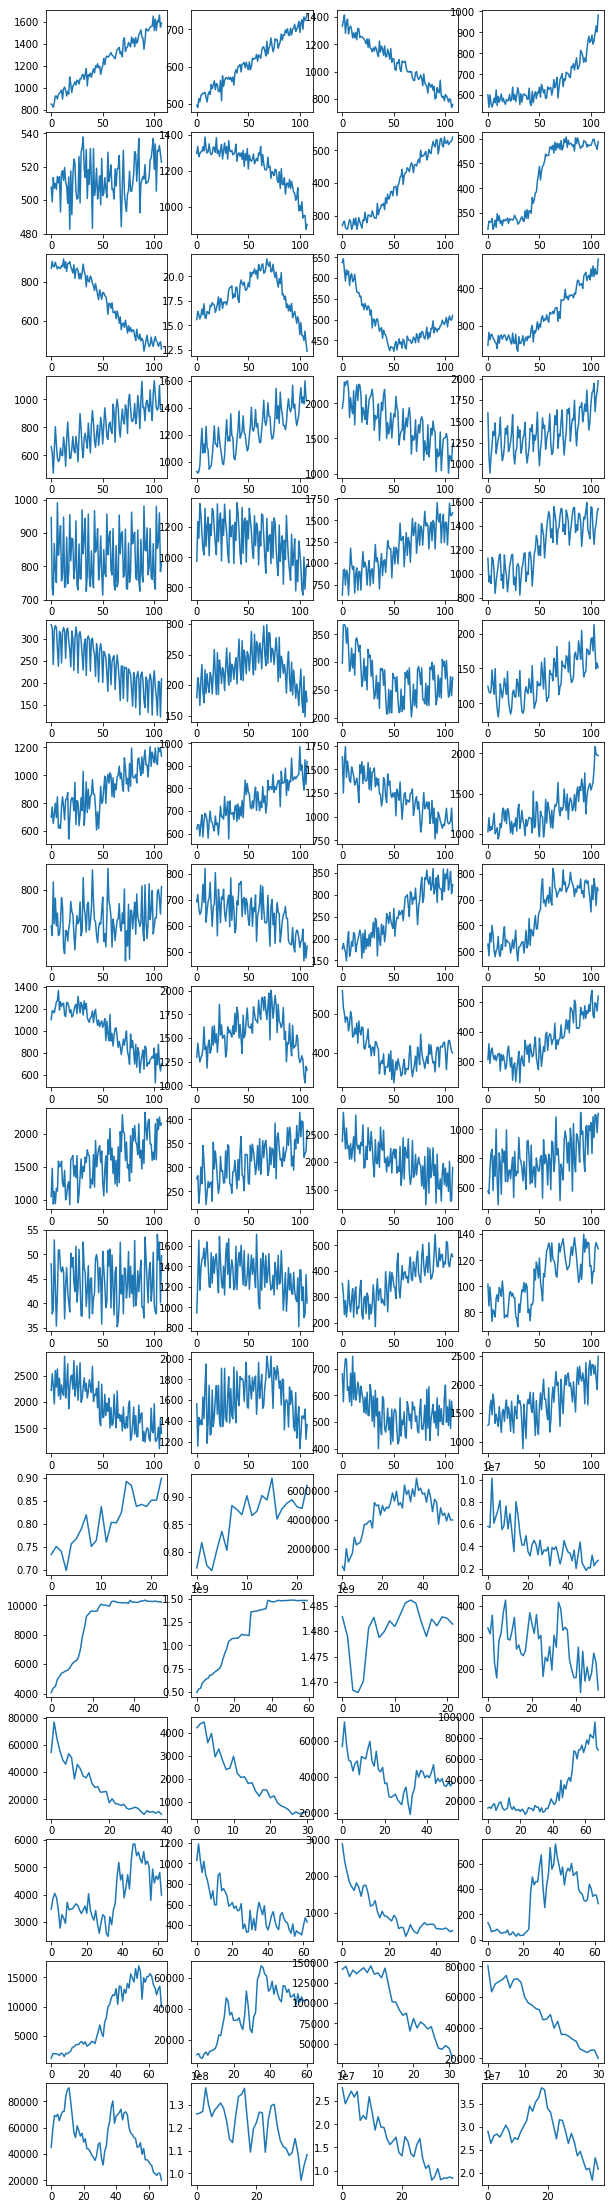

In [7]:
# Plot the series
plt.rcParams['figure.figsize'] = (10, 40) 

fig = plt.figure()
for i in range(1,len(values)+1):
    fig.add_subplot(len(values)//4,4,i)
    plt.plot(values['ts'+str(i)])

## Model each serie with the same LSTM model
 - Restart the notebook if change the serie

In [8]:
# Serie to model
serie='ts71'

In [9]:
# Use 14 historical data to predict
x_length = 14

# Forecast interval
y_length = forecast[serie]

print(x_length, y_length)


# Separate for validation the last 3 cases
num_validation_cases = 3
max_index_train = len(values[serie]) - y_length - x_length - num_validation_cases
max_index_valid = max_index_train + num_validation_cases

# Create data
X_trn = []
X_val = []
y_trn = []
y_val = []
for i in range(max_index_train):
    X_trn += [values[serie][i:i+x_length]]
    y_trn += [values[serie][i+x_length:i+x_length+y_length]]
for i in range(max_index_train, max_index_valid):
    X_val += [values[serie][i:i+x_length]]
    y_val += [values[serie][i+x_length:i+x_length+y_length]]
    
X_trn = np.array(X_trn)
X_val = np.array(X_val)
y_trn = np.array(y_trn)
y_val = np.array(y_val)

print(X_trn.shape, X_val.shape,y_trn.shape, y_val.shape)


14 6
(15, 14) (3, 14) (15, 6) (3, 6)


In [10]:
print(np.max(X_trn),np.max(y_trn))

27872951.542 19280042.602


In [11]:
# Normalize
max_trn = max((np.max(X_trn),np.max(y_trn)))
print('max_trn: ', max_trn)
X_trn = X_trn/max_trn
X_val = X_val/max_trn
y_trn = y_trn/max_trn
y_val = y_val/max_trn

        

max_trn:  27872951.542


In [12]:
# Model
lstm_feat = 256

gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

def dense(x, input_size=10, otput_size=1):
    W = tf.Variable(tf.truncated_normal([input_size, otput_size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[otput_size]))
    return tf.matmul(x,W) + b


#Inputs
x_input = tf.placeholder(tf.float32, shape=[None, x_length], name='x')
x_input_lstm = tf.reshape(x_input, [-1, x_length, 1])
y_input = tf.placeholder(tf.float32, shape=[None, y_length], name='y')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')
lstm1 = tf.contrib.rnn.LSTMCell(lstm_feat, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123))
lstm1 = tf.contrib.rnn.DropoutWrapper(lstm1, output_keep_prob=keep_prob)
lstm_out, _ = tf.nn.dynamic_rnn(lstm1, x_input_lstm, dtype=tf.float32, scope='lstm16')

#Final dense layer
y_pred = dense(lstm_out[:,-1,:], input_size=lstm_feat, otput_size=y_length)
print(y_pred)

# Loss function
cost  = tf.reduce_sum(tf.square(y_pred - y_input))

numerator = tf.abs(y_pred-y_input)
denominator = tf.divide(tf.abs(y_pred) + tf.abs(y_input), 2)
SMAPE_cost = tf.divide(tf.reduce_sum(tf.divide(numerator, denominator)), y_length)


# Trainer
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
train_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(SMAPE_cost)

Tensor("add:0", shape=(?, 6), dtype=float32)


In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
# Train graph
num_epoch=500
lr=0.001

i=0
for epoch in range(num_epoch):
    feed_dict={x_input: X_trn, y_input: y_trn, learning_rate: lr, keep_prob: 0.9}
    _, c = sess.run([train_step, cost], feed_dict=feed_dict)
    i += 1
    if i%100==0:
        c_tst = cost.eval(feed_dict={x_input: X_val, y_input:  y_val, keep_prob: 1})   
        print('Epoch: ', epoch, ' - LR: ',lr, ' - Cost: ',c, ' - Cost test: ',c_tst )
    lr *= 0.999

Epoch:  99  - LR:  0.0009056978449586675  - Cost:  0.928333  - Cost test:  0.104259
Epoch:  199  - LR:  0.000819468297776412  - Cost:  0.553448  - Cost test:  0.142386
Epoch:  299  - LR:  0.0007414484806367366  - Cost:  0.636605  - Cost test:  0.217084
Epoch:  399  - LR:  0.0006708567627695095  - Cost:  0.368636  - Cost test:  0.0606319
Epoch:  499  - LR:  0.0006069859307919766  - Cost:  0.371012  - Cost test:  0.0509844


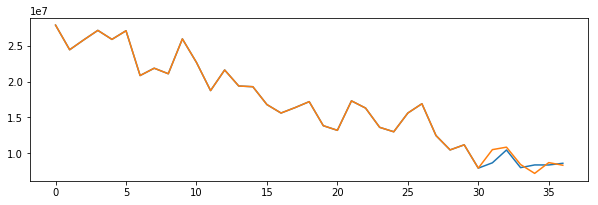

In [18]:
# Evaluate val prediction
y_pred_val = y_pred.eval(feed_dict={x_input: X_val, y_input:  y_val, keep_prob: 1})  
pred_val = np.concatenate((values[serie][:-y_length-1], y_pred_val[-1]*max_trn), axis=0)

plt.rcParams['figure.figsize'] = (10, 3) 
real_vs_pred = np.array([ values[serie][:-1], pred_val]).T
plt.plot(real_vs_pred)

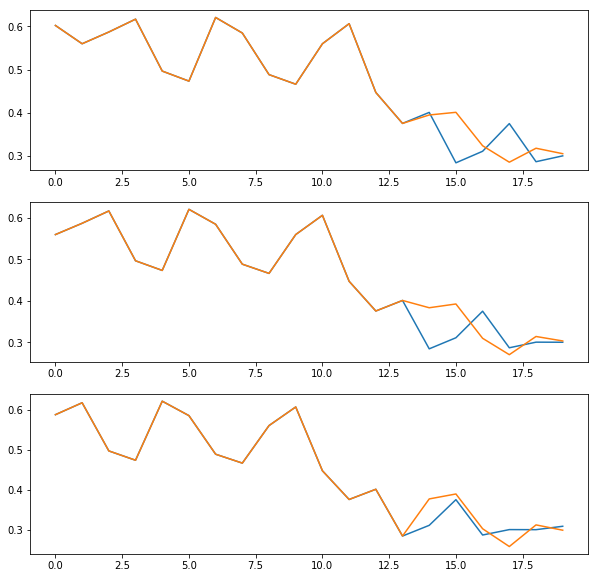

In [21]:
# Evaluate val prediction all validation data
y_pred_val = y_pred.eval(feed_dict={x_input: X_val, keep_prob: 1})  
pred_val = np.concatenate((X_val, y_pred_val), axis=1)
val = np.concatenate((X_val, y_val), axis=1)

plt.rcParams['figure.figsize'] = (10, 10) 
fig = plt.figure()
for i in range(3):
    fig.add_subplot(3,1,i+1)
    real_vs_pred = np.array([ val[i], pred_val[i]]).T
    plt.plot(real_vs_pred)